# LAB 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from scipy.optimize import root as get_root
from sklearn.cluster import DBSCAN, KMeans
from sympy import *
from scipy.signal import find_peaks

plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.dpi"] = 100

# Task 1

In [16]:
rc = 3.56995 # values above this will lead to chaotic behaviour
Feigenbaum1 = 2.502907
reps = 1000 # number of map iterations
a = 1e-2 # a small perturbation to the map
N = 50000 # number of sub-intervals in r

interval = (2.8, rc)
lims = []
lims_perturbed = []
Lyapunov_exponents = []
rs = []

dr = (interval[-1] - interval[0]) / N
r = interval[0]

def logistic_map(x, r):
    return r*x*(1 - x)

def perturbation(x):
    return a*x**4

def diff(x, r): # Derivative of the Logistic map 
    return r*(1 - 2*x)

for _ in tqdm(range(N)):
    
    temp_lims = []
    temp_lims_perturbed = []
    
    initial_val = np.random.rand()
    temp_lims.append(initial_val)
    temp_lims_perturbed.append(initial_val)
        
    for i in range(reps-1):
        val = logistic_map(temp_lims[i], r)
        temp_lims.append(val)
        temp_lims_perturbed.append(val + perturbation(temp_lims[i]))
        
    lims.append(temp_lims)
    lims_perturbed.append(temp_lims_perturbed)
    
    # temp_lims have 1000 values of x for some fixed r
    # computing the Lyapunov exponent
    l = np.log(np.abs(diff(np.array(temp_lims), r))).mean()
    Lyapunov_exponents.append(l)
    
    rs.append(r)  # Store r values for later use
    r += dr # updating r
    
lims = np.array(lims)
lims_perturbed = np.array(lims_perturbed)

100%|██████████| 50000/50000 [01:42<00:00, 487.82it/s]


(<matplotlib.legend.Legend at 0x2420ff16f70>,
 None,
 Text(0, 0.5, 'fixed points x'),
 Text(0.5, 0, 'r'))

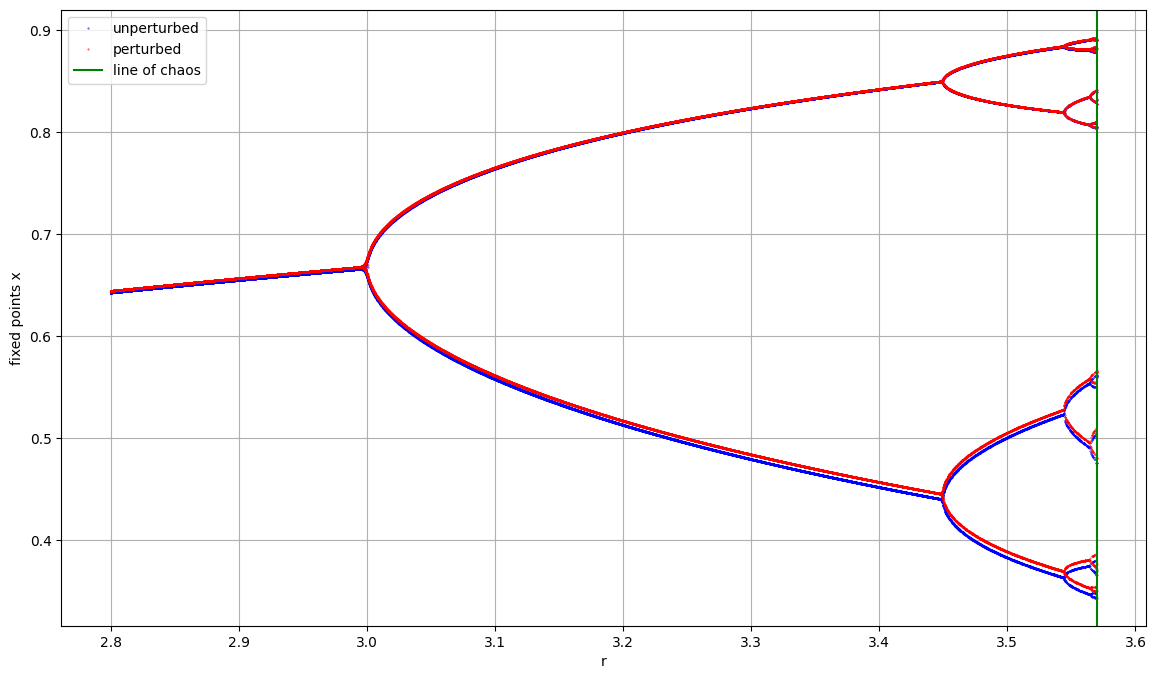

In [17]:
mod = 1
plt.plot(rs[::mod], lims[::mod,-1], "b.", ms=0.7, label="unperturbed")
plt.plot(rs[::mod], lims_perturbed[::mod,-1], "r.", ms=0.7, label="perturbed")
plt.axvline(rc, color="green", label="line of chaos")

plt.legend(), plt.grid(), plt.ylabel("fixed points x"), plt.xlabel("r")

# Task 2
Compute the Feigenbaum constants $\alpha\approx 2.5029$ and $\beta\approx4.6692$
for both maps.

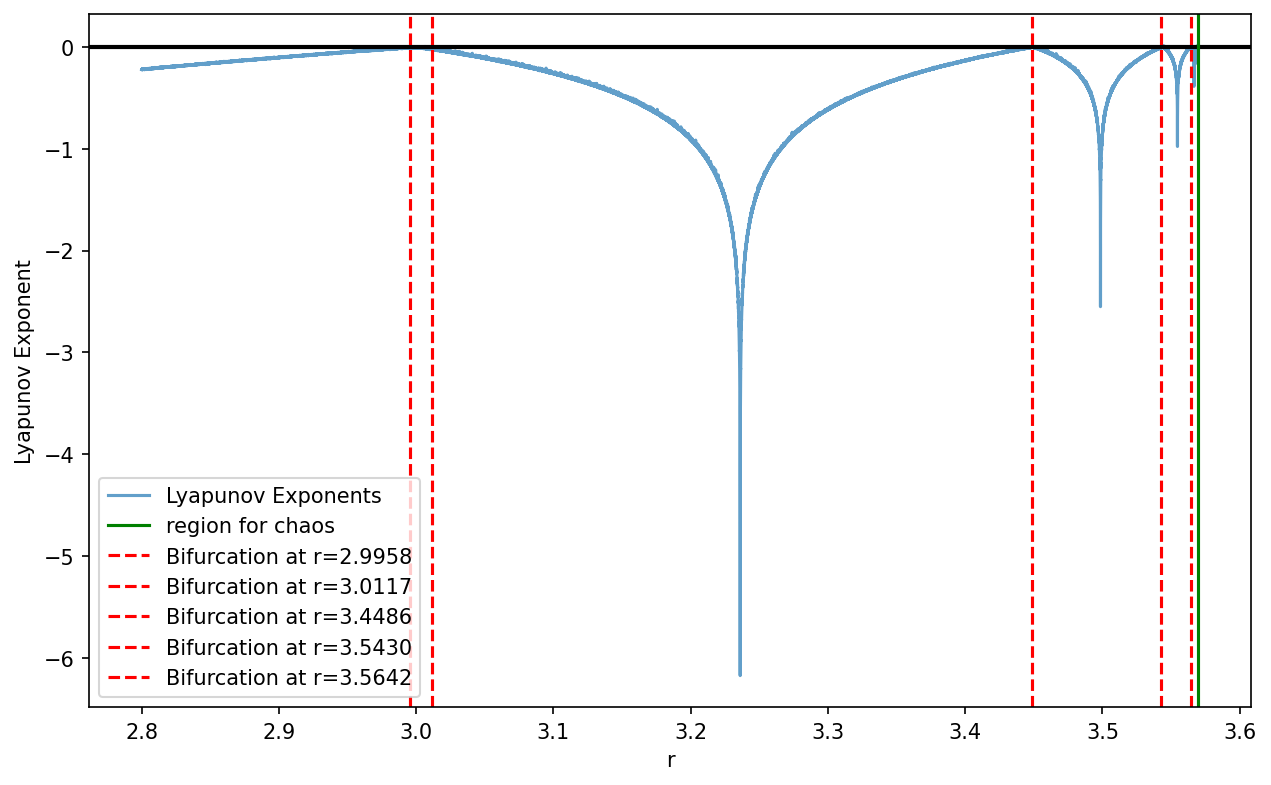

In [23]:
# Find bifurcation points using a sliding window approach
window_size = 40  # Size of the sliding window
threshold = 1e-3  # Minimum Lyapunov exponent value to detect a bifurcation
saddle_node_bifurcations = []

# Loop over Lyapunov exponent values using a sliding window
for i in range(len(Lyapunov_exponents) - window_size):
    # Create a sliding window of Lyapunov exponent values
    window = Lyapunov_exponents[i:i + window_size]
    
    # Find the index of the minimum absolute value of the Lyapunov exponent in the window
    min_idx = np.argmin(np.abs(window))
    
    # If the absolute value of the average Lyapunov exponent is below the threshold, then a bifurcation point is detected
    if np.abs(window[min_idx]) < threshold:
        # Get the corresponding r value for the bifurcation point
        r_bifurcation = rs[i + min_idx]
        
        # Avoid detecting multiple bifurcation points within the same region
        if not saddle_node_bifurcations or (r_bifurcation - max(saddle_node_bifurcations)) > 0.01:
            # Add the bifurcation point to the list of saddle-node bifurcations
            saddle_node_bifurcations.append(r_bifurcation)


# Plot Lyapunov exponents with respect to r
plt.figure(figsize=[10, 6], dpi=150)
plt.plot(rs, Lyapunov_exponents, label='Lyapunov Exponents', alpha=0.7)
plt.axhline(0, color="k", lw=2)
plt.axvline(rc, label="region for chaos", color="green")

# Plot computed saddle node bifurcations
for r_bifurcation in saddle_node_bifurcations:
    plt.axvline(x=r_bifurcation, color='r', linestyle='--', label=f'Bifurcation at r={r_bifurcation:.4f}')

# Set labels and legend
plt.xlabel('r')
plt.ylabel('Lyapunov Exponent')
plt.legend()
plt.savefig("unperturbed_Lyapunov_exponents", bbox_inches="tight")

In [24]:
a0, a1, a2 = saddle_node_bifurcations[-3:]
print(a0, a1, a2)
Estimated_Feigenbaum1  = (a1 - a0) / (a2 - a1)
print(f"{Estimated_Feigenbaum1 = :.2f}")

3.4485596830011382 3.542986351001304 3.5642369710013413
Estimated_Feigenbaum1 = 4.44


# Plotting the bifurcation diagram

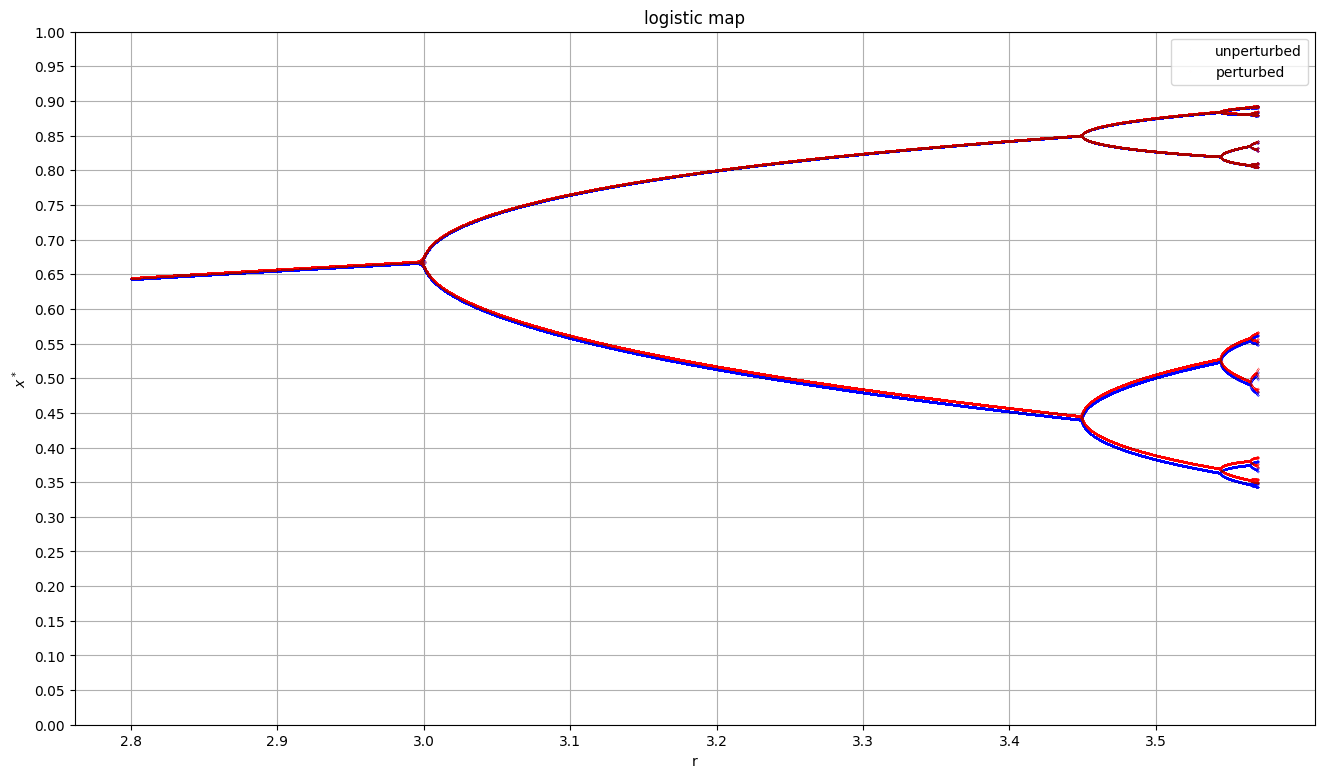

In [30]:
numtoplot = 50

fig, biax = plt.subplots(figsize=(16, 9))

# create arrays of x-coordinates and y-coordinates for unperturbed data
r_vals = np.array(rs)
x_vals = lims[:, -numtoplot:]
r_broadcasted = np.broadcast_to(r_vals[:, None], (len(r_vals), numtoplot))
biax.plot(r_broadcasted.flatten(), x_vals.flatten(), 'b.', markersize=.02, label="unperturbed")

# create arrays of x-coordinates and y-coordinates for perturbed data
x2_vals = lims_perturbed[:, -numtoplot:]
biax.plot(r_broadcasted.flatten(), x2_vals.flatten(), 'r.', markersize=.02, label="perturbed")

biax.set(xlabel='r', ylabel='$x^*$', title='logistic map')
plt.xticks(np.arange(*interval, 0.1))
plt.yticks(np.arange(0, 1+0.05, 0.05))
plt.grid()
plt.legend()
plt.show()
#plt.savefig("logistic map (blue) - perturbed map (red)", bbox_inches="tight")

In [32]:
import numpy as np
from scipy.optimize import fsolve


def g(x, alpha, delta):
    return np.array([
        x[0] - alpha * x[1] * (1 - x[1]),
        x[1] - alpha * x[2] * (1 - x[2]),
        x[2] - alpha * x[3] * (1 - x[3]),
        x[3] - alpha * x[0] * (1 - x[0]),
        delta * x[1] * (1 - 2 * x[1]) - x[0] * (x[3] - x[1]),
        delta * x[2] * (1 - 2 * x[2]) - x[1] * (x[0] - x[2]),
        delta * x[3] * (1 - 2 * x[3]) - x[2] * (x[1] - x[3]),
        delta * x[0] * (1 - 2 * x[0]) - x[3] * (x[2] - x[0]),
    ])


def find_feigenbaum_constants():
    x0 = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
    alpha_delta_guess = np.array([2.5, 4.0])
    
    def equations(alpha_delta):
        alpha, delta = alpha_delta
        x = fsolve(g, x0, args=(alpha, delta))
        return [
            x[0] - alpha * x[1] * (1 - x[1]),
            delta * x[1] * (1 - 2 * x[1]) - x[0] * (x[3] - x[1]),
        ]

    alpha, delta = fsolve(equations, alpha_delta_guess)

    return alpha, delta


alpha, delta = find_feigenbaum_constants()
print(f"The first Feigenbaum constant (δ) to 5 significant digits: {delta:.5f}")


The first Feigenbaum constant (δ) to 5 significant digits: 4.11822


C:\Users\Wenha\Anaconda\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [37]:
import numpy as np
from scipy.optimize import newton

# Generate some sample data for g(x) and f(x)
x_data = np.linspace(-10, 10, 100)
x_data = x_data[x_data != 0]

g_data = np.random.rand(len(x_data))
f_data = np.random.rand(len(x_data))

# Fit even-degree polynomials for g(x) and f(x) using least squares
degree = 4
g_coeffs = np.polyfit(x_data, g_data, degree)[::2]
f_coeffs = np.polyfit(x_data, f_data, degree)[::2]

# Define the given even functions g(x) and f(x) as fitted polynomials
def g(x):
    return np.polyval(g_coeffs, x)

def f(x):
    return np.polyval(f_coeffs, x)

# Define their derivatives using finite differences
def g_prime(x, h=1e-5):
    return (g(x + h) - g(x - h)) / (2 * h)

def f_prime(x, h=1e-5):
    return (f(x + h) - f(x - h)) / (2 * h)

# Define the given equations
def equation_1(x, alpha):
    return g(alpha * x) / alpha - g(g(x))

def equation_2(x, alpha, delta):
    return delta * f(alpha * x) / alpha - g_prime(g(x)) * f(x) + f(g(x))

# Define the Newton-Raphson method
def newton_raphson(alpha, delta, x0, max_iter=1000, tol=1e-6):  # Change tol=1e-6

    x = x0
    for _ in range(max_iter):
        eq1 = equation_1(x, alpha)
        eq2 = equation_2(x, alpha, delta)
        eq_sum = eq1 + eq2

        if abs(eq_sum) < tol:
            return x

        x -= eq_sum / (equation_1(x + tol, alpha) + equation_2(x + tol, alpha, delta) - eq_sum + 1e-6) / tol


    raise Exception("No solution found")

# Define the target function to minimize
def target_function(alpha, delta=1):
    try:
        x = newton_raphson(alpha, delta, x0=1)
        b = x
        c = g(x)
        d = f(x)
        return b, c**2 + d**2
    except Exception:
        return np.inf, np.inf

# Optimize alpha
alpha_range = np.linspace(0.1, 10, 100)
opt_alpha = None
min_bc = np.inf

for alpha in alpha_range:
    b, bc = target_function(alpha)
    if bc < min_bc:
        min_bc = bc
        opt_alpha = alpha

print("Optimal alpha:", opt_alpha)


C:\Users\Wenha\Anaconda\lib\site-packages\numpy\lib\polynomial.py:779: RuntimeWarning: overflow encountered in multiply
  @array_function_dispatch(_binary_op_dispatcher)


Optimal alpha: None


# Task 3

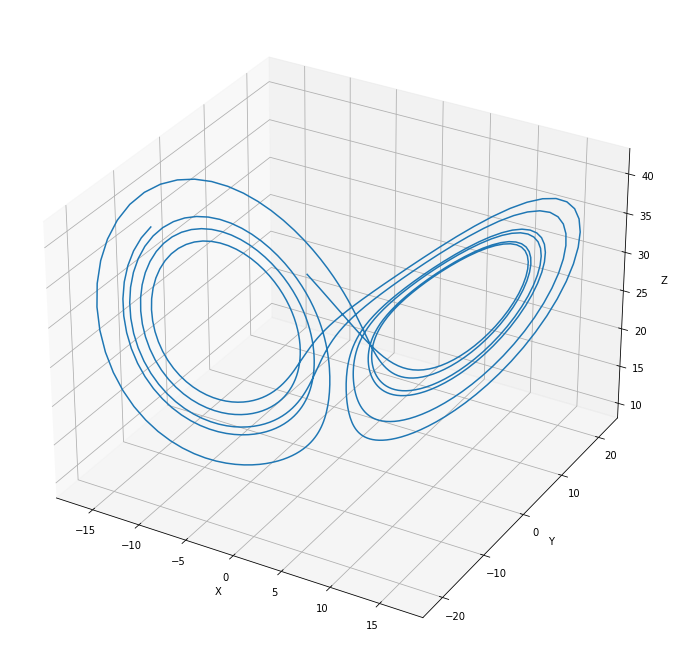

In [15]:
# plotting the solutions to the Lorentz system
def plot_array_3d(arr):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(*arr.T)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
# runge-kutta fourth-order numerical integration
@njit
def rk4(func, tk, _yk, _dt=0.01):
    """
    single-step fourth-order numerical integration (RK4) method
    func: system of first order ODEs
    tk: current time step
    _yk: current state vector [y1, y2, y3, ...]
    _dt: discrete time step size
    **kwargs: additional parameters for ODE system
    returns: y evaluated at time k+1
    """

    # evaluate derivative at several stages within time interval
    f1 = func(tk, _yk)
    f2 = func(tk + _dt / 2, _yk + (f1 * (_dt / 2)))
    f3 = func(tk + _dt / 2, _yk + (f2 * (_dt / 2)))
    f4 = func(tk + _dt, _yk + (f3 * _dt))

    # return an average of the derivative over tk, tk + dt
    return _yk + (_dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4)

@njit
def lorenz(_t, _y, sigma=10, beta=(8 / 3), rho=28):
    """
    lorenz chaotic differential equation: dy/dt = f(t, y)
    _t: time tk to evaluate system
    _y: 3D state vector [x, y, z]
    sigma: constant related to Prandtl number
    beta: geometric physical property of fluid layer
    rho: constant related to the Rayleigh number
    return: [x_dot, y_dot, z_dot]
    """
    return np.array([
        sigma * (_y[1] - _y[0]),
        _y[0] * (rho - _y[2]) - _y[1],
        (_y[0] * _y[1]) - (beta * _y[2]),
    ])

yk = np.array([-7, 8, 26])

dt = 0.01
time = np.arange(0.0, 20, dt)
state_history = []

# iterate over time
for t in time:
    state_history.append(yk)
    yk = rk4(lorenz, t, yk, dt)
    
state_history = np.array(state_history)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot(*state_history.T)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#plt.savefig("lorenz attractor", bbox_inches="tight")

# Task 4
1. Choose some initial condition such that it is attracted by the Lorentz system.
2. Definition of Lyapunov exponent: 
$$\lambda = \frac{1}{n}\sum_{i=0}^{n-1}\ln{\abs{f'(x_i)}}$$. What happens when $n$ becomes big? Is $\lambda$ positive or negative? What does it mean?

In [261]:
sigma = 10 
rho = 28 
beta = 8/3

yk = np.array([-7, 8, 26])

dt = 0.01
time = np.arange(0.0, 20, dt)
state_history = []
v = []

# iterate over time
for t in time:
    x, y, z = yk
    v.append(
        [sigma*(y-x), x*(rho-z) - y, x*y - beta*z]
    )
    
    state_history.append(yk)
    yk = rk4(lorenz, t, yk, dt)

    
state_history = np.array(state_history)
v = np.array(v)
Lyapunov_exponents = np.log(np.abs(v)).mean(0)
print(Lyapunov_exponents, "for x, y, z")

[3.2418655  3.26999055 3.85881722] for x, y, z


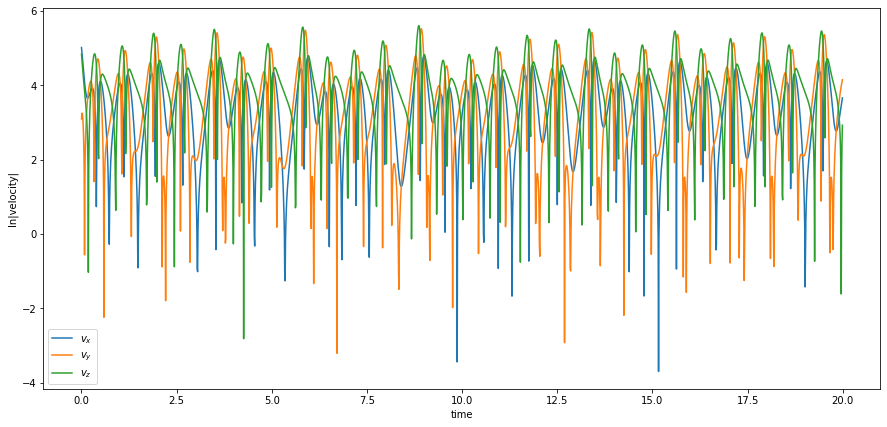

In [270]:
plt.plot(time, np.log(np.abs(v))[:,0], label="$v_x$")
plt.plot(time, np.log(np.abs(v))[:,1], label="$v_y$")
plt.plot(time, np.log(np.abs(v))[:,2], label="$v_z$")

plt.xlabel("time")
plt.ylabel("ln|velocity|")
plt.legend()
plt.savefig("log_abs_J", bbox_inches="tight")